## What the codebase can support now
------
Two games, 1D vector feature inputs

In [1]:
import gym

In [6]:
# env = gym.make('LunarLander-v2')
env = gym.make('CartPole-v1')
env.reset()

array([-0.0134566 , -0.02709758, -0.03354747, -0.00018994])

In [23]:
env.step(env.action_space.sample())

(array([-0.06697994, -0.98592291, -0.01881073,  1.09356332]), 1.0, False, {})

In [12]:
# Created by Andrew Silva on 8/28/19
import gym
import numpy as np
import torch
from interpretable_ddts.agents.ddt_agent import DDTAgent
from interpretable_ddts.agents.mlp_agent import MLPAgent
from interpretable_ddts.opt_helpers.replay_buffer import discount_reward
import torch.multiprocessing as mp
import argparse
import copy
import random
import os

from tqdm.notebook import tqdm


def run_episode(q, agent_in, ENV_NAME, seed=0):
    agent = agent_in.duplicate()
    if ENV_NAME == 'lunar':
        env = gym.make('LunarLander-v2')
    elif ENV_NAME == 'cart':
        env = gym.make('CartPole-v1')
    else:
        raise Exception('No valid environment selected')
    done = False
    torch.manual_seed(seed)
    env.seed(seed)
    np.random.seed(seed)
    env.action_space.seed(seed)
    random.seed(seed)
    state = env.reset()  # Reset environment and record the starting state

    while not done:
        action = agent.get_action(state)
        # Step through environment using chosen action
        state, reward, done, _ = env.step(action)
        # env.render()
        # Save reward
        agent.save_reward(reward)
        if done:
            break
    reward_sum = np.sum(agent.replay_buffer.rewards_list)
    rewards_list, advantage_list, deeper_advantage_list = discount_reward(agent.replay_buffer.rewards_list,
                                                                          agent.replay_buffer.value_list,
                                                                          agent.replay_buffer.deeper_value_list)
    agent.replay_buffer.rewards_list = rewards_list
    agent.replay_buffer.advantage_list = advantage_list
    agent.replay_buffer.deeper_advantage_list = deeper_advantage_list

    to_return = [reward_sum, copy.deepcopy(agent.replay_buffer.__getstate__())]
    if q is not None:
        try:
            q.put(to_return)
        except RuntimeError as e:
            print(e)
            return to_return
    return to_return


def main(episodes, agent, ENV_NAME):
    running_reward_array = []
    if not os.path.exists('../models/'):
        os.mkdir('../models/')
    for episode in tqdm(range(episodes), desc='episode'):
        reward = 0
        returned_object = run_episode(None, agent_in=agent, ENV_NAME=ENV_NAME)
        reward += returned_object[0]
        running_reward_array.append(returned_object[0])
        agent.replay_buffer.extend(returned_object[1])
        if reward >= 499:
            agent.save('../models/'+str(episode)+'th')
        agent.end_episode(reward)

        running_reward = sum(running_reward_array[-100:]) / float(min(100.0, len(running_reward_array)))
        if episode % 50 == 0:
            print(f'Episode {episode}  Last Reward: {reward}  Average Reward: {running_reward}')
        if episode % 500 == 0:
            agent.save('../models/'+str(episode)+'th')

    return running_reward_array


In [7]:
import sys
sys.argv = ['testrun',
            '-gpu',
            '-env', 'lunar']

In [ ]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("-a", "--agent_type", help="architecture of agent to run", type=str, default='ddt')
    parser.add_argument("-e", "--episodes", help="how many episodes", type=int, default=1000)
    parser.add_argument("-l", "--num_leaves", help="number of leaves for DDT/DRL ", type=int, default=4)
    parser.add_argument("-n", "--num_hidden", help="number of hidden layers for MLP ", type=int, default=0)
    parser.add_argument("-env", "--env_type", help="environment to run on", type=str, default='cart')
    parser.add_argument("-gpu", help="run on GPU?", action='store_true')

    args = parser.parse_args()
    print(f"input arguments {args}")
    
    
    AGENT_TYPE = args.agent_type  # 'ddt', 'mlp'
    NUM_EPS = args.episodes  # num episodes Default 1000
    ENV_TYPE = args.env_type  # 'cart' or 'lunar' Default 'cart'
    USE_GPU = args.gpu  # Applies for 'prolo' only. use gpu? Default false
    if ENV_TYPE == 'lunar':
        init_env = gym.make('LunarLander-v2')
        dim_in = init_env.observation_space.shape[0]
        dim_out = init_env.action_space.n
    elif ENV_TYPE == 'cart':
        init_env = gym.make('CartPole-v1')
        dim_in = init_env.observation_space.shape[0]
        dim_out = init_env.action_space.n
    else:
        raise Exception('No valid environment selected')

    print(f"Agent {AGENT_TYPE} on {ENV_TYPE} ")
    # mp.set_start_method('spawn')
    mp.set_sharing_strategy('file_system')
    for i in range(5):
        bot_name = AGENT_TYPE + '_' + ENV_TYPE
        if USE_GPU:
            bot_name += '_GPU_'
        if AGENT_TYPE == 'ddt':
            policy_agent = DDTAgent(bot_name=bot_name,
                                    input_dim=dim_in,
                                    output_dim=dim_out,
                                    rule_list=False,
                                    num_rules=args.num_leaves)
        elif AGENT_TYPE == 'mlp':
            policy_agent = MLPAgent(input_dim=dim_in,
                                    bot_name=bot_name,
                                    output_dim=dim_out,
                                    num_hidden=args.num_hidden)
        else:
            raise Exception('No valid network selected')
        reward_array = main(NUM_EPS, policy_agent, ENV_TYPE)


input arguments Namespace(agent_type='ddt', env_type='lunar', episodes=1000, gpu=True, num_hidden=0, num_leaves=4)
Agent ddt on lunar 


Episode 0  Last Reward: -141.38449639721102  Average Reward: -141.38449639721102
Episode 50  Last Reward: -268.3299956986182  Average Reward: -239.57945563274947
Episode 100  Last Reward: -661.7041534927689  Average Reward: -380.84048331829007
Episode 150  Last Reward: -803.439844655393  Average Reward: -614.1282171745711
Episode 200  Last Reward: -880.9674847152235  Average Reward: -776.4900365617389
Episode 250  Last Reward: -692.7540027543866  Average Reward: -853.4683804628032
Episode 300  Last Reward: -835.3598241380892  Average Reward: -857.0173753661479
Episode 350  Last Reward: -871.0311845460166  Average Reward: -855.729001404035
Episode 400  Last Reward: -859.8061183577315  Average Reward: -840.4170041944824
Episode 450  Last Reward: -865.5074692261323  Average Reward: -839.8493667578606
Episode 500  Last Reward: -994.5552361582555  Average Reward: -869.7882886691809
Episode 550  Last Reward: -939.871232992491  Average Reward: -898.3459178467033
Episode 600  Last Reward: -717

Episode 0  Last Reward: -141.38449639721102  Average Reward: -141.38449639721102
Episode 50  Last Reward: -268.3299956986182  Average Reward: -239.57945563274947
Episode 100  Last Reward: -661.7041534927689  Average Reward: -380.84048331829007
Episode 150  Last Reward: -803.439844655393  Average Reward: -614.1282171745711
Episode 200  Last Reward: -880.9674847152235  Average Reward: -776.4900365617389
Episode 250  Last Reward: -692.7540027543866  Average Reward: -853.4683804628032
Episode 300  Last Reward: -835.3598241380892  Average Reward: -857.0173753661479
Episode 350  Last Reward: -871.0311845460166  Average Reward: -855.729001404035
Episode 400  Last Reward: -859.8061183577315  Average Reward: -840.4170041944824
Episode 450  Last Reward: -865.5074692261323  Average Reward: -839.8493667578606
Episode 500  Last Reward: -994.5552361582555  Average Reward: -869.7882886691809
Episode 550  Last Reward: -939.871232992491  Average Reward: -898.3459178467033
Episode 600  Last Reward: -717

Episode 0  Last Reward: -141.38449639721102  Average Reward: -141.38449639721102
Episode 50  Last Reward: -268.3299956986182  Average Reward: -239.57945563274947
Episode 100  Last Reward: -661.7041534927689  Average Reward: -380.84048331829007
Episode 150  Last Reward: -803.439844655393  Average Reward: -614.1282171745711
Episode 200  Last Reward: -880.9674847152235  Average Reward: -776.4900365617389
Episode 250  Last Reward: -692.7540027543866  Average Reward: -853.4683804628032
Episode 300  Last Reward: -835.3598241380892  Average Reward: -857.0173753661479
Episode 350  Last Reward: -871.0311845460166  Average Reward: -855.729001404035
Episode 400  Last Reward: -859.8061183577315  Average Reward: -840.4170041944824
Episode 450  Last Reward: -865.5074692261323  Average Reward: -839.8493667578606


## Toybox test

----
The expectation is to have a long 1D vector as input just as shown in the case of Cartpole or lunar lander

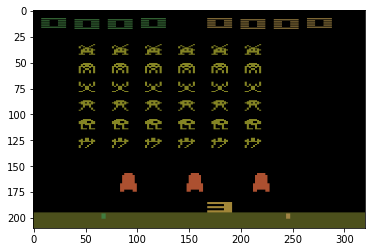

In [96]:
from toybox import Toybox, Input    # @yxie20
import gym
from matplotlib.pyplot import imshow
get_ipython().run_line_magic('matplotlib', 'inline')

env_id = "SpaceInvadersToyboxNoFrameskip-v4"
env = gym.make(env_id)
assert 'NoFrameskip' in env.spec.id
# dir(env.toybox)

state = env.toybox.state_to_json()
imshow(env.toybox.get_rgb_frame())

# for brick in state['bricks']:
#     brick['position']['y'] += 40

env.toybox.write_state_json(state)
imshow(env.toybox.get_rgb_frame())

In [105]:
env.step(env.action_space.sample())

(array([[[ 0],
         [ 0],
         [ 0],
         ...,
         [ 0],
         [ 0],
         [ 0]],
 
        [[ 0],
         [ 0],
         [ 0],
         ...,
         [ 0],
         [ 0],
         [ 0]],
 
        [[ 0],
         [ 0],
         [ 0],
         ...,
         [ 0],
         [ 0],
         [ 0]],
 
        ...,
 
        [[75],
         [75],
         [75],
         ...,
         [75],
         [75],
         [75]],
 
        [[75],
         [75],
         [75],
         ...,
         [75],
         [75],
         [75]],
 
        [[75],
         [75],
         [75],
         ...,
         [75],
         [75],
         [75]]], dtype=uint8),
 0,
 False,
 {'lives': 3, 'score': 0})

In [101]:
state = env.toybox.state_to_json()
state.keys()

dict_keys(['rand', 'life_display_timer', 'lives', 'level', 'score', 'ship', 'ship_laser', 'shields', 'enemies', 'enemies_movement', 'enemy_shot_delay', 'enemy_lasers', 'ufo'])